In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/NLP/Article Tagging')
!ls

'Article Tagging.ipynb'   sample_sub.csv   Tags.csv   Test.csv	 Train.csv


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set(style="whitegrid")

import xgboost as xgb
import gc
from tqdm import tqdm
from sklearn.svm import SVC

import tensorflow
from tensorflow.keras.layers import LSTM,GRU,Dense,Activation,Dropout,Embedding,BatchNormalization
from tensorflow.keras.utils import to_categorical


from sklearn import preprocessing,decomposition,model_selection,metrics,pipeline
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV,KFold
from sklearn.metrics import accuracy_score,f1_score,classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB

from lightgbm import LGBMRegressor
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.simplefilter('ignore')
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing import sequence,text
from tensorflow.keras.callbacks import EarlyStopping

import nltk
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

stop_words = stopwords.words('english')

import seaborn as sns
import string
!pip install unidecode
import unidecode
import re
!pip install scikit-multilearn
from skmultilearn.problem_transform import LabelPowerset# initialize label powerset multi-label classifier
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 4.0 MB/s eta 0:00:00


In [15]:
train = pd.read_csv('Train.csv')

test = pd.read_csv('Test.csv')

ss = pd.read_csv('sample_sub.csv')

tags = pd.read_csv('Tags.csv')

In [16]:
ss

,id,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,Computer Vision and Pattern Recognition,Cosmology and Nongalactic Astrophysics,Data Structures and Algorithms,Differential Geometry,...,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,9409,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17934,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16071,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16870,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10496,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5997,11506,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5998,3418,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5999,7369,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6000,8421,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
train.head(3)
test.head(3)
tags.head(3)

,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,...,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,1824,a ever-growing datasets inside observational a...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3094,we propose the framework considering optimal $...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8463,nanostructures with open shell transition meta...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics
0,9409,fundamental frequency (f0) approximation from ...,0,0,0,1
1,17934,"this large-scale study, consisting of 24.5 mil...",1,0,0,1
2,16071,we present a stability analysis of the plane c...,0,0,1,0


,Tags
0,Analysis of PDEs
1,Applications
2,Artificial Intelligence


In [18]:
ID_COL = 'id'


TARGET_COLS = ['Analysis of PDEs', 'Applications',
               'Artificial Intelligence', 'Astrophysics of Galaxies',
               'Computation and Language', 'Computer Vision and Pattern Recognition',
               'Cosmology and Nongalactic Astrophysics',
               'Data Structures and Algorithms', 'Differential Geometry',
               'Earth and Planetary Astrophysics', 'Fluid Dynamics',
               'Information Theory', 'Instrumentation and Methods for Astrophysics',
               'Machine Learning', 'Materials Science', 'Methodology', 'Number Theory',
               'Optimization and Control', 'Representation Theory', 'Robotics',
               'Social and Information Networks', 'Statistics Theory',
               'Strongly Correlated Electrons', 'Superconductivity',
               'Systems and Control']


TOPIC_COLS = ['Computer Science','Mathematics','Physics','Statistics']

In [19]:
len(TARGET_COLS)

25

In [20]:
print(f'\n->->->| Train contains {train.shape[0]} samples and {train.shape[1]} variables')

print(f'\n->->->| Test contains {test.shape[0]} samples and {test.shape[1]} variables')

print(f'\n->->->| Number of distinct SUB TOPICS is {len(TARGET_COLS)}')

features = [c for c in train.columns if c not in [ID_COL] + TARGET_COLS]

print(f'\n->->->| The dataset contains {len(features)} features')


->->->| Train contains 14004 samples and 31 variables

->->->| Test contains 6002 samples and 6 variables

->->->| Number of distinct SUB TOPICS is 25

->->->| The dataset contains 5 features


In [21]:
100 * (train[TARGET_COLS].sum()/(train.shape[0])).sort_values(ascending=False)

,0
Machine Learning,27.313625
Artificial Intelligence,9.825764
Robotics,6.812339
Computer Vision and Pattern Recognition,6.705227
Strongly Correlated Electrons,6.376750
Materials Science,5.534133
Computation and Language,4.605827
Cosmology and Nongalactic Astrophysics,4.520137
Optimization and Control,4.434447
Social and Information Networks,4.420166


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14004 entries, 0 to 14003
Data columns (total 31 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   id                                            14004 non-null  int64 
 1   ABSTRACT                                      14004 non-null  object
 2   Computer Science                              14004 non-null  int64 
 3   Mathematics                                   14004 non-null  int64 
 4   Physics                                       14004 non-null  int64 
 5   Statistics                                    14004 non-null  int64 
 6   Analysis of PDEs                              14004 non-null  int64 
 7   Applications                                  14004 non-null  int64 
 8   Artificial Intelligence                       14004 non-null  int64 
 9   Astrophysics of Galaxies                      14004 non-null  int64 
 10

In [23]:
null_values_per_variable = 100 * (train.isnull().sum()/train.shape[0]).round(3)
null_values_per_variable.sort_values(ascending=False)

,0
id,0.0
Fluid Dynamics,0.0
Superconductivity,0.0
Strongly Correlated Electrons,0.0
Statistics Theory,0.0
Social and Information Networks,0.0
Robotics,0.0
Representation Theory,0.0
Optimization and Control,0.0
Number Theory,0.0


In [24]:
train.nunique()

,0
id,14004
ABSTRACT,14004
Computer Science,2
Mathematics,2
Physics,2
Statistics,2
Analysis of PDEs,2
Applications,2
Artificial Intelligence,2
Astrophysics of Galaxies,2


In [25]:
train[TOPIC_COLS].sum().sort_values(ascending=False)

,0
Computer Science,5884
Physics,3856
Statistics,3794
Mathematics,2831


In [26]:
100 * (train[TARGET_COLS].sum()/train.shape[0]).sort_values(ascending=False)

,0
Machine Learning,27.313625
Artificial Intelligence,9.825764
Robotics,6.812339
Computer Vision and Pattern Recognition,6.705227
Strongly Correlated Electrons,6.376750
Materials Science,5.534133
Computation and Language,4.605827
Cosmology and Nongalactic Astrophysics,4.520137
Optimization and Control,4.434447
Social and Information Networks,4.420166


In [27]:
from wordcloud import WordCloud,STOPWORDS

wc = WordCloud(stopwords=set(list(STOPWORDS) + ['inside']),random_state=42)

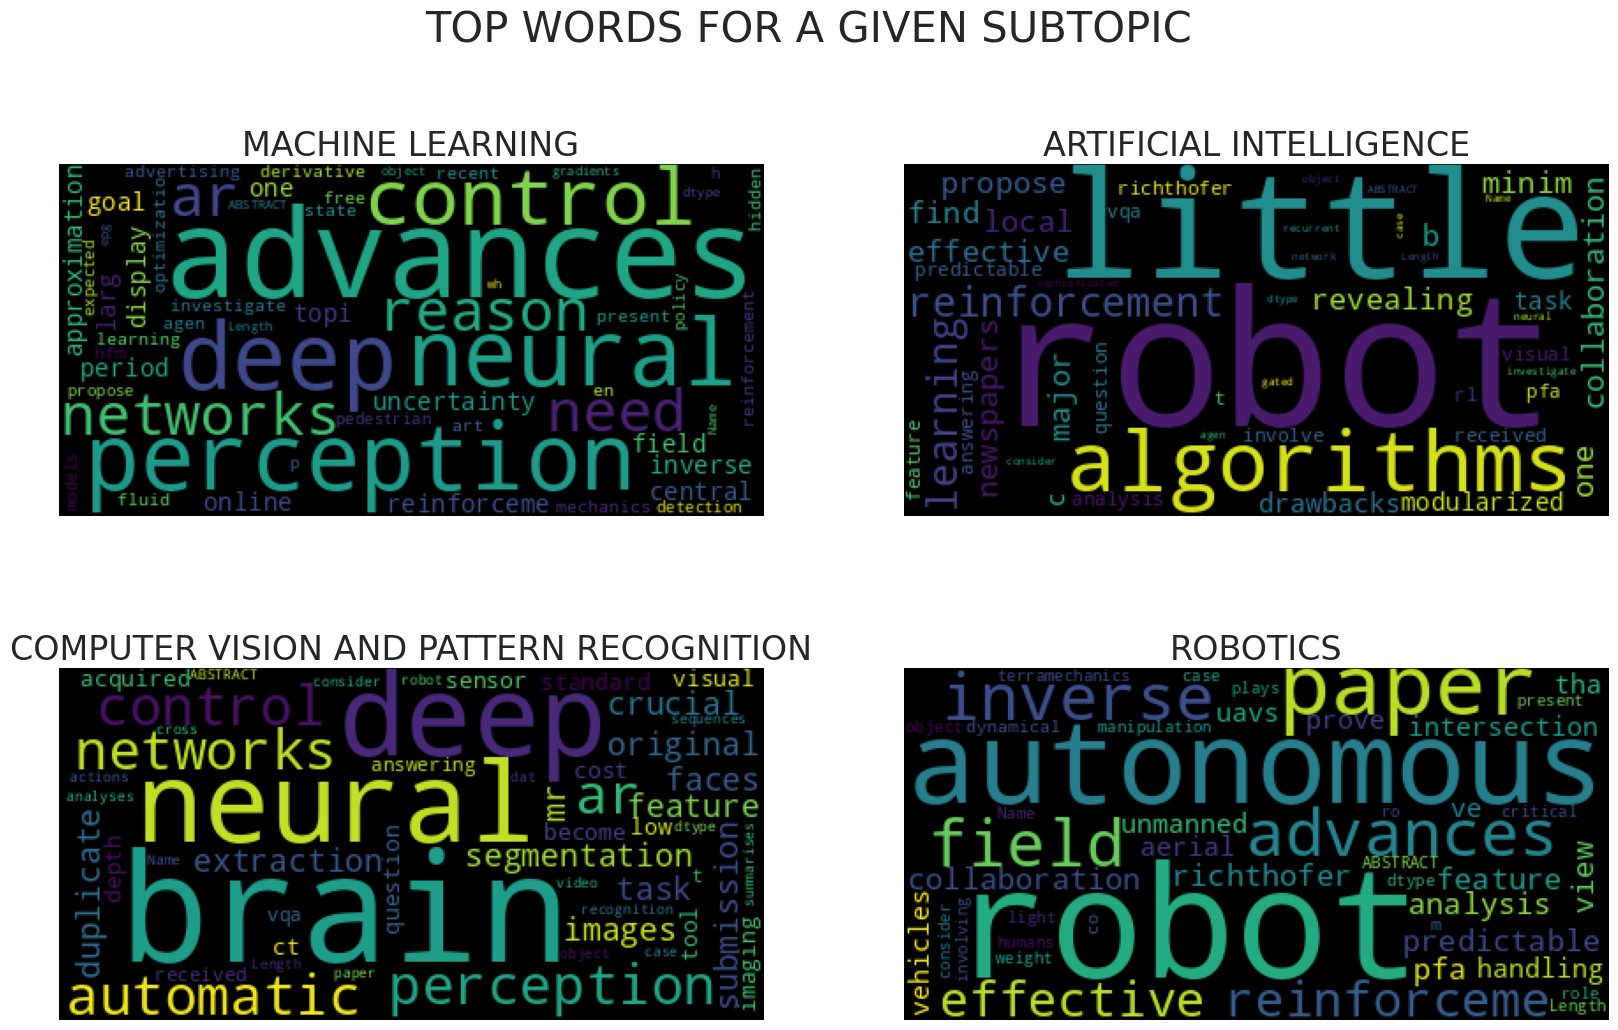

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]
for i, sub_topic_name in enumerate(['Machine Learning', 'Artificial Intelligence', 'Computer Vision and Pattern Recognition', 'Robotics']):
  sub_topic = train[train[sub_topic_name] == 1]
  op = wc.generate(str(sub_topic['ABSTRACT']))
  _ = axes[i].imshow(op)
  _ = axes[i].set_title(sub_topic_name.upper(), fontsize=24)
  _ = axes[i].axis('off')
_ = plt.suptitle('TOP WORDS FOR A GIVEN SUBTOPIC', fontsize=30)

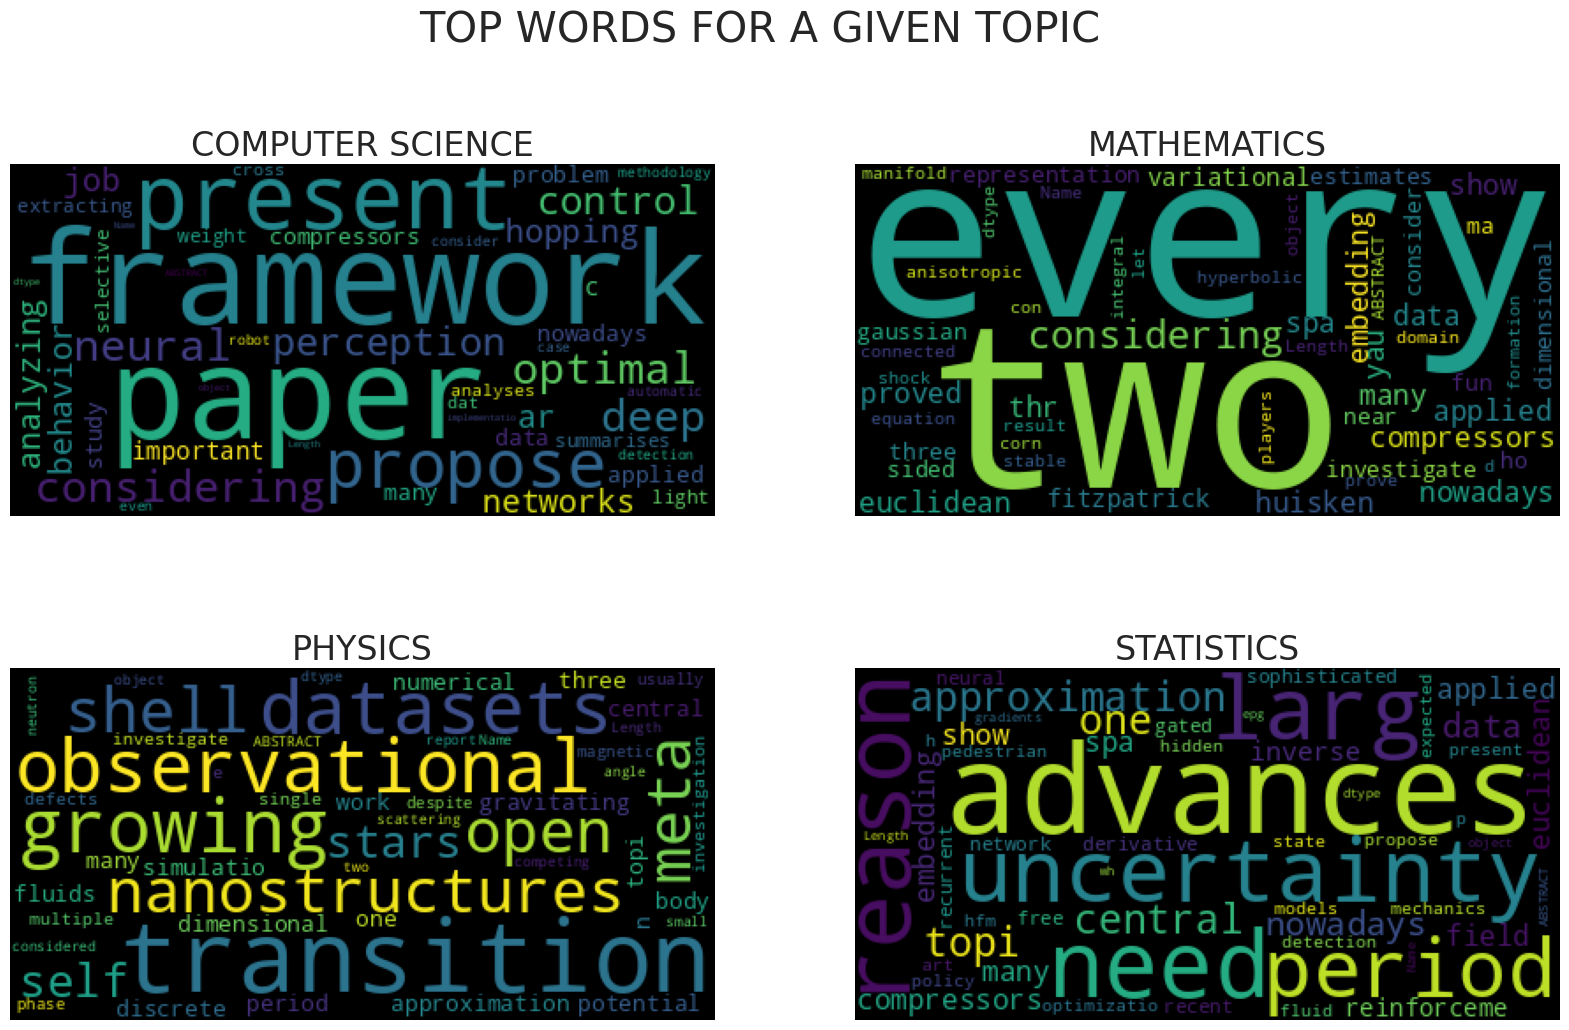

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]
for i, sub_topic_name in enumerate(TOPIC_COLS):
  sub_topic = train[train[sub_topic_name] == 1]
  op = wc.generate(str(sub_topic['ABSTRACT']))
  _ = axes[i].imshow(op)
  _ = axes[i].set_title(sub_topic_name.upper(), fontsize=24)
  _ = axes[i].axis('off')
_ = plt.suptitle('TOP WORDS FOR A GIVEN TOPIC', fontsize=30)

In [30]:
sent1 = 'Artificial Intelligence is the future'
sent2 = 'Analytics Vidhya is the best platform to learn Artificial Intelligence'
sent3 = 'To build a better future the way forward is to learn and improve constantly'

In [31]:
all_sentences = [sent1,sent2,sent3]

all_words = [w for sent in all_sentences for w in sent.split()]
all_words = list(set(all_words))
all_words

['Artificial',
 'future',
 'forward',
 'improve',
 'best',
 'way',
 'is',
 'To',
 'build',
 'the',
 'platform',
 'learn',
 'constantly',
 'and',
 'Vidhya',
 'a',
 'better',
 'Intelligence',
 'Analytics',
 'to']

In [33]:
columns = {word : [] for word in all_words}
for word in all_words:
  for sent in all_sentences:
    sent_words = sent.split()
    count = sum([(word == w) for w in sent_words])
    columns[word].append(count)

In [34]:
sent1 = 'Artificial Intelligence is the future '
sent2 = 'Analytics Vidhya is the best platform to learn Artificial Intelligence'
sent3 = 'To build a better future the way forward is to learn and improve constantly'

In [35]:
counts = pd.DataFrame(columns)

In [36]:
counts

,Artificial,future,forward,improve,best,way,is,To,build,the,platform,learn,constantly,and,Vidhya,a,better,Intelligence,Analytics,to
0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,1,0,1,0,0,1,1,1,0,0,1,0,0,1,1,1
2,0,1,1,1,0,1,1,1,1,1,0,1,1,1,0,1,1,0,0,1


In [37]:
vec = CountVectorizer(max_features=10000)
combined = list(train['ABSTRACT']) + list(test['ABSTRACT'])
vec.fit(combined)

CountVectorizer(max_features=10000)

In [38]:
trn,val = train_test_split(train,test_size=0.2,random_state=2)

In [39]:
trn_abs = vec.transform(trn['ABSTRACT'])
val_abs = vec.transform(val['ABSTRACT'])
tst_abs = vec.transform(test['ABSTRACT'])

In [42]:
trn[TARGET_COLS]

,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,Computer Vision and Pattern Recognition,Cosmology and Nongalactic Astrophysics,Data Structures and Algorithms,Differential Geometry,Earth and Planetary Astrophysics,...,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
6036,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6168,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5724,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
11745,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13896,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6637,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2575,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [43]:
clf = OneVsRestClassifier(LogisticRegression(C=10,n_jobs=-1))
clf.fit(trn_abs,trn[TARGET_COLS])

OneVsRestClassifier(estimator=LogisticRegression(C=10, n_jobs=-1))

In [44]:
val_preds = clf.predict(val_abs)
f1_score(val[TARGET_COLS],val_preds,average='micro')

0.6266266266266266

In [45]:
preds_test = clf.predict(tst_abs)

In [46]:
def download_preds(preds_test,file_name='hacklive_sub.csv'):
  ss[TARGET_COLS] = preds_test
  ss.to_csv(file_name,index=False)

In [47]:
download_preds(preds_test,'hacklive_NLP_count.csv')

In [48]:
counts

,Artificial,future,forward,improve,best,way,is,To,build,the,platform,learn,constantly,and,Vidhya,a,better,Intelligence,Analytics,to
0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,1,0,1,0,0,1,1,1,0,0,1,0,0,1,1,1
2,0,1,1,1,0,1,1,1,1,1,0,1,1,1,0,1,1,0,0,1


In [49]:
sent1 = 'Artificial Intelligence is the future'
sent2 = 'Analytics Vidhya is the best platform to learn Artificial Intelligence'
sent3 = 'To build a better future the way forward is to learn and improve constantly'

In [50]:
term_frequency = counts.copy()
term_frequency = term_frequency.apply(lambda x: x/term_frequency.sum(axis=1))
term_frequency

,Artificial,future,forward,improve,best,way,is,To,build,the,platform,learn,constantly,and,Vidhya,a,better,Intelligence,Analytics,to
0,0.2,0.200000,0.000000,0.000000,0.0,0.000000,0.200000,0.000000,0.000000,0.200000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.2,0.0,0.000000
1,0.1,0.000000,0.000000,0.000000,0.1,0.000000,0.100000,0.000000,0.000000,0.100000,0.1,0.100000,0.000000,0.000000,0.1,0.000000,0.000000,0.1,0.1,0.100000
2,0.0,0.071429,0.071429,0.071429,0.0,0.071429,0.071429,0.071429,0.071429,0.071429,0.0,0.071429,0.071429,0.071429,0.0,0.071429,0.071429,0.0,0.0,0.071429


In [51]:
inverse_document_frequency = counts.copy()
inverse_document_frequency = inverse_document_frequency.apply(lambda x:3/(x>0).sum())
inverse_document_frequency

,0
Artificial,1.5
future,1.5
forward,3.0
improve,3.0
best,3.0
way,3.0
is,1.0
To,3.0
build,3.0
the,1.0


In [52]:
tfidf = term_frequency * inverse_document_frequency
tfidf

,Artificial,future,forward,improve,best,way,is,To,build,the,platform,learn,constantly,and,Vidhya,a,better,Intelligence,Analytics,to
0,0.30,0.300000,0.000000,0.000000,0.0,0.000000,0.200000,0.000000,0.000000,0.200000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.30,0.0,0.000000
1,0.15,0.000000,0.000000,0.000000,0.3,0.000000,0.100000,0.000000,0.000000,0.100000,0.3,0.150000,0.000000,0.000000,0.3,0.000000,0.000000,0.15,0.3,0.150000
2,0.00,0.107143,0.214286,0.214286,0.0,0.214286,0.071429,0.214286,0.214286,0.071429,0.0,0.107143,0.214286,0.214286,0.0,0.214286,0.214286,0.00,0.0,0.107143


In [54]:
vec = TfidfVectorizer(max_features=10000)
_ = vec.fit(list(train['ABSTRACT']) + list(test['ABSTRACT']))

trn_abs = vec.transform(trn['ABSTRACT'])
val_abs = vec.transform(val['ABSTRACT'])
tst_abs = vec.transform(test['ABSTRACT'])

clf = OneVsRestClassifier(LogisticRegression(C=10,n_jobs=-1))
_ = clf.fit(trn_abs,trn[TARGET_COLS])

val_preds = clf.predict(val_abs)
f1_score(val[TARGET_COLS],val_preds,average='micro')

0.6313107182672401

In [55]:
preds_test = clf.predict(tst_abs)
download_preds(preds_test,'hacklive_NLP_tfidf.csv')

In [56]:
def get_best_thresholds(true,preds):
  thresholds = [i/100 for i in range(100)]
  best_thresholds = []
  for idx in range(25):
    f1_scores = [f1_score(true[:,idx],(preds[:,idx]>thresh)*1) for thresh in thresholds]
    best_thresh = thresholds[np.argmax(f1_scores)]
    best_thresholds.append(best_thresh)
  return best_thresholds

In [57]:
val_preds = clf.predict_proba(val_abs)

best_thresholds = get_best_thresholds(val[TARGET_COLS].values,val_preds)

for i,thresh in enumerate(best_thresholds):
  val_preds[:,i] = (val_preds[:,i] > thresh) * 1

f1_score(val[TARGET_COLS],val_preds,average='micro')

0.6914124709053044

In [59]:
preds_test = clf.predict_proba(tst_abs)

for i,thresh in enumerate(best_thresholds):
  preds_test[:,i] = (preds_test[:,i]>thresh) * 1

download_preds(preds_test,'hacklive_NLP_tfidf_threshold_optimized.csv')

In [60]:
TOPIC_COLS

['Computer Science', 'Mathematics', 'Physics', 'Statistics']

In [61]:
trn_abs.shape

(11203, 10000)

In [63]:
vec = TfidfVectorizer(max_features=10000)
_ = vec.fit(list(train['ABSTRACT']) + list(test['ABSTRACT']))

trn_abs = vec.transform(trn['ABSTRACT'])
val_abs = vec.transform(val['ABSTRACT'])
tst_abs = vec.transform(test['ABSTRACT'])

trn2 = np.hstack((trn_abs.toarray(),trn[TOPIC_COLS]))
val2 = np.hstack((val_abs.toarray(),val[TOPIC_COLS]))
tst2 = np.hstack((tst_abs.toarray(),test[TOPIC_COLS]))

print(trn2.shape,val2.shape,tst2.shape)

(11203, 10004) (2801, 10004) (6002, 10004)


In [65]:
from scipy.sparse import csr_matrix

trn2 = csr_matrix(trn2.astype('int16'))
val2 = csr_matrix(val2.astype('int16'))
tst2 = csr_matrix(tst2.astype('int16'))

In [66]:
clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1))
_  = clf.fit(trn2, trn[TARGET_COLS])

val_preds = clf.predict_proba(val2)
best_thresholds = get_best_thresholds(val[TARGET_COLS].values, val_preds)

for i, thresh in enumerate(best_thresholds):
  val_preds[:, i] = (val_preds[:, i] > thresh) * 1

f1_score(val[TARGET_COLS], val_preds, average='micro')

0.34794350981826366

In [67]:
preds_test = clf.predict_proba(tst2)

for i, thresh in enumerate(best_thresholds):
  preds_test[:, i] = (preds_test[:, i] > thresh) * 1

download_preds(preds_test, 'hacklive_NLP_count_added_topics.csv')

In [68]:
train['text'] = ' '
test['text'] = ' '


train['text'] += train['ABSTRACT']
test['text'] += test['ABSTRACT']

trn,val = train_test_split(train,test_size=0.2,random_state=2)

In [69]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tok = Tokenizer(num_words=1000000)
tok.fit_on_texts(train['text'].str.lower().tolist()+test['text'].str.lower().tolist())

vocab_size = len(tok.word_index) +1

In [70]:
X_trn = tok.texts_to_sequences(trn['text'])
X_val = tok.texts_to_sequences(val['text'])
X_test = tok.texts_to_sequences(test['text'])

In [73]:
maxlen = 200
X_trn = pad_sequences(X_trn,maxlen=maxlen)
X_val = pad_sequences(X_val,maxlen=maxlen)
X_test = pad_sequences(X_test,maxlen=maxlen)

In [75]:
from tensorflow.keras.models import Sequential

embedding_dim = 50
vocab_size = len(tok.word_index) + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=maxlen))

model.add(Flatten())
model.add(Dense(200,activation='relu',name='Fully_Connected'))
model.add(Dense(25,activation='sigmoid',name='Output'))
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              )
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fully_Connected (Dense)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [77]:
model.fit(X_trn,trn[TARGET_COLS],validation_data=(X_val,val[TARGET_COLS]),verbose=True,epochs=20,batch_size=256,
          callbacks=[tensorflow.keras.callbacks.ReduceLROnPlateau()])

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.1275 - loss: 0.3628 - val_accuracy: 0.1696 - val_loss: 0.1936 - learning_rate: 0.0010
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1847 - loss: 0.1856 - val_accuracy: 0.2238 - val_loss: 0.1726 - learning_rate: 0.0010
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2868 - loss: 0.1585 - val_accuracy: 0.2888 - val_loss: 0.1553 - learning_rate: 0.0010
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3787 - loss: 0.1339 - val_accuracy: 0.3377 - val_loss: 0.1399 - learning_rate: 0.0010
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5287 - loss: 0.1081 - val_accuracy: 0.3934 - val_loss: 0.1290 - learning_rate: 0.0010
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6639 - loss: 0.0834 - val_accuracy: 0.4288 - val_loss: 0.1229 - learning_rate: 0.0010
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7448 - loss: 0.0619 - val_accuracy:

In [78]:
def get_best_thresholds(true, preds):
  thresholds = [i/100 for i in range(100)]
  best_thresholds = []
  for idx in range(25):
    f1_scores = [f1_score(true[:, idx], (preds[:, idx] > thresh) * 1) for thresh in thresholds]
    best_thresh = thresholds[np.argmax(f1_scores)]
    best_thresholds.append(best_thresh)
  return best_thresholds

val_preds = model.predict(X_val)
best_thresholds = get_best_thresholds(val[TARGET_COLS].values, val_preds)
for i, thresh in enumerate(best_thresholds):
  val_preds[:, i] = (val_preds[:, i] > thresh) * 1
f1_score(val[TARGET_COLS], val_preds, average='micro')

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


0.5407858593096859

In [79]:
preds_test =  model.predict(X_test)

for i,thresh in enumerate(best_thresholds):
  preds_test[:,i] = (preds_test[:,i] > thresh) * 1


download_preds(preds_test,'hacklive_NLP_word_embeddings.csv')

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
